# 2D Benign Overfitting Experiment
This notebook demonstrates benign overfitting in a neural network using PyTorch with CUDA support.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Data Generation

In [2]:
def generate_data(n_samples=10000):
    x = np.random.uniform(-1, 1, n_samples)
    y = np.random.uniform(-1, 1, n_samples)
    z = np.sin(2 * np.pi * (x + y)) + np.random.normal(0, 0.1, n_samples)
    return np.column_stack((x, y)), z

X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and move to device
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).unsqueeze(1).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: torch.Size([8000, 2])
Test set shape: torch.Size([2000, 2])


## 2. Model Architecture

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=2, width=1024, depth=3):
        super(NeuralNetwork, self).__init__()
        layers = [nn.Linear(input_dim, width), nn.ReLU()]
        for _ in range(depth - 1):
            layers.extend([nn.Linear(width, width), nn.ReLU()])
        layers.append(nn.Linear(width, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1, bias=True)
  )
)


## 3. Training Process

In [4]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        train_loss = criterion(model(X_train), y_train).item()
        val_loss = criterion(model(X_test), y_test).item()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [10/100], Train Loss: 0.0194, Val Loss: 0.0197
Epoch [20/100], Train Loss: 0.0130, Val Loss: 0.0132
Epoch [30/100], Train Loss: 0.0213, Val Loss: 0.0216
Epoch [40/100], Train Loss: 0.0122, Val Loss: 0.0122
Epoch [50/100], Train Loss: 0.0139, Val Loss: 0.0149
Epoch [60/100], Train Loss: 0.0160, Val Loss: 0.0171
Epoch [70/100], Train Loss: 0.0125, Val Loss: 0.0122
Epoch [80/100], Train Loss: 0.0110, Val Loss: 0.0114
Epoch [90/100], Train Loss: 0.0143, Val Loss: 0.0141
Epoch [100/100], Train Loss: 0.0120, Val Loss: 0.0117


## 4. Evaluation

In [5]:
model.eval()
with torch.no_grad():
    train_loss = criterion(model(X_train), y_train).item()
    test_loss = criterion(model(X_test), y_test).item()

print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Final Training Loss: 0.0120
Final Test Loss: 0.0117


## 5. Visualization

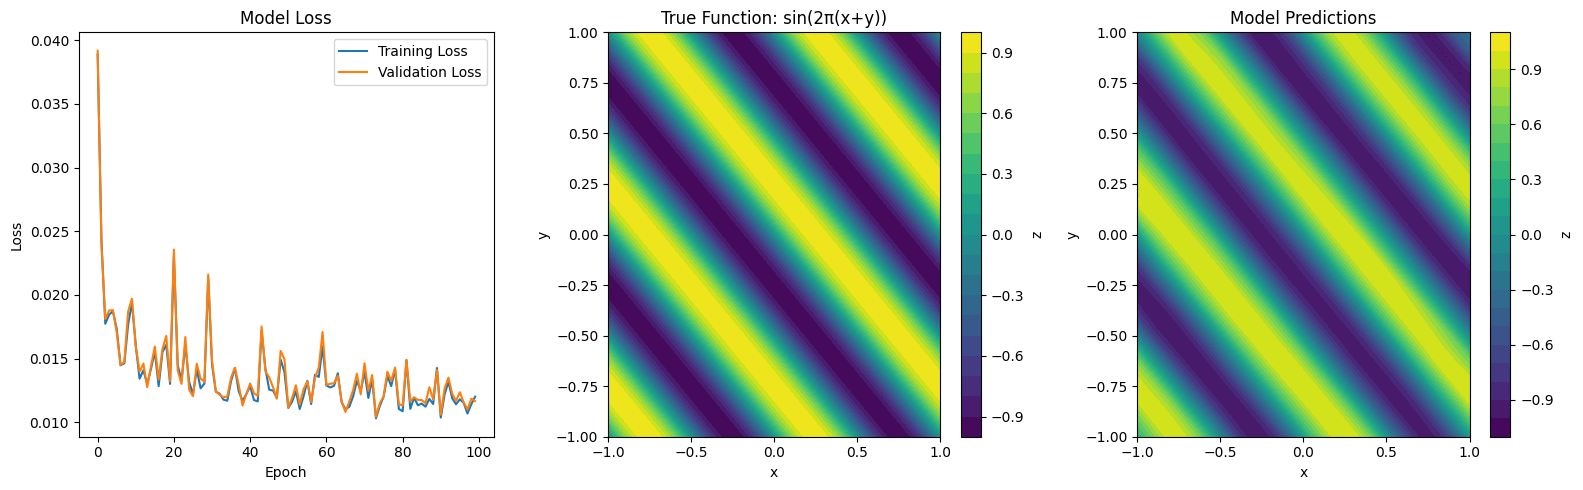

In [6]:
def plot_results():
    plt.figure(figsize=(16, 5))
    
    # Plot training history
    plt.subplot(131)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot true function
    plt.subplot(132)
    x = y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.sin(2 * np.pi * (X + Y))
    plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(label='z')
    plt.title('True Function: sin(2π(x+y))')
    plt.xlabel('x')
    plt.ylabel('y')
    
    # Plot model predictions
    plt.subplot(133)
    x = y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    input_tensor = torch.FloatTensor(np.column_stack((X.ravel(), Y.ravel()))).to(device)
    Z = model(input_tensor).cpu().detach().numpy().reshape(X.shape)
    plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(label='z')
    plt.title('Model Predictions')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.tight_layout()
    plt.show()

plot_results()

## Conclusion

This experiment demonstrates benign overfitting in a neural network:
1. The model has many more parameters than data points, allowing it to potentially memorize the training data.
2. It achieves very low training error (overfitting to the training data).
3. Despite this overfitting, it still generalizes well to the test set and accurately reproduces the underlying function.

The visualization shows that the model has learned to approximate the true function sin(2π(x+y)) very closely, despite the presence of noise in the training data.